# Fees analysis

Analysis of Monero fee data

Neptune & Isthmus

## Import Libraries
(if you have any issues with the next cell, run `pip install -r requirements.txt` to install dependencies)

In [1]:
import isthmuslib  # == 0.0.71
import pandas as pd
import pathlib
from typing import Tuple, List, Any
from numpy import vectorize
from math import floor, log10
import math
import matplotlib.pyplot as plt
import numpy as np
import hdbscan
from copy import deepcopy

## Set parameters

In [2]:
data_file_path = pathlib.Path.cwd() / 'data' / 'local_only' / 'fees.csv'
cache_plots_path: pathlib.Path.cwd() = pathlib.Path.cwd() / 'output' / 'local_only' 

## Import data

Load from file

In [3]:
%%time
monero = isthmuslib.Timeseries().read_csv(data_file_path, inplace=False, basis_col_name='block_height')

CPU times: user 14.7 s, sys: 1.17 s, total: 15.9 s
Wall time: 15.9 s


## Feature engineering

Some misc tweaks: Drop NaNs, 0's, and convert the fee from atomic units to base

In [4]:
monero.data.dropna(inplace=True)
monero.data.tx_fee = monero.data.tx_fee / 1e12  
monero.data = monero.data[monero.data.tx_fee > 0]  # 0's break log scales and are not important in this analysis

Create a fee column with only 1 significant fee

In [5]:
one_sig_fig = vectorize(lambda x: round(x, -int(floor(log10(abs(x))))) if x > 0 else 0)
monero.data['tx_fee_1sf'] = one_sig_fig(monero.data.tx_fee)

Create a column where every fee is a multiple of some base

In [6]:
basis: float = 1.5  # Fiddle with this parameter to adjust the spacing between the fee levels

@np.vectorize
def round_to_multiple(fee: float, basis: float = 1.5) -> float:
    return basis ** floor(math.log(fee, basis)) if fee else 0

monero.data['tx_fee_multiple'] = round_to_multiple(monero.data.tx_fee, basis=basis)

Peek the result

In [7]:
monero.data.head()

,block_height,tx_hash,tx_fee,tx_fee_1sf,tx_fee_multiple
890806,1220517,\x6f6f2eea2e549a69ad10246511ccc720193f1d41c9fa...,0.026,0.03,0.017342
890807,1220517,\xc22dddbc73076825b163f048122f759cfd983fff9a4b...,0.026,0.03,0.017342
890808,1220517,\x027e42a0337a4902ff888bcfc334a81964403e29226d...,0.026,0.03,0.017342
890809,1220517,\xd0499e22757bf94692958f29e1e2f8f328ce366618c6...,0.026,0.03,0.017342
890810,1220517,\x316bac1402e03f03418bcaea890e8af457138fd1761a...,0.026,0.03,0.017342


## Data visualizations

Prevent scrolling

In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Set some preferences for visual style

In [9]:
monero.color = (1, 102/256, 0)
monero.watermark_fontsize = 15
monero.grid = False
monero.watermark_text = 'Neptune & Isthmus'
monero.figsize = (15,12)
monero.label_fontsize = 18
monero.title_fontsize = 23
monero.rosetta.stone = {'block_height': 'Block height', 'tx_fee': 'Transaction Fee (XMR)', 'tx_fee_1sf': 'Transaction Fee (XMR)\nrounded to 1 decimal significant figure', 'tx_fee_multiple':f'Transaction fee (XMR)\nRounded to multiples of {basis}'}
field_title_tuples: List[Tuple[str, str]] =[
    ('tx_fee', 'Monero fees (real chain data)'),
    ('tx_fee_1sf', 'Monero fees (rounded to 1 sig fig)'),
    ('tx_fee_multiple', f'Monero fees (rounded to multiple of {basis})')];

Block height distribution (which should be the same as transaction volume, so this is more of a sanity check)

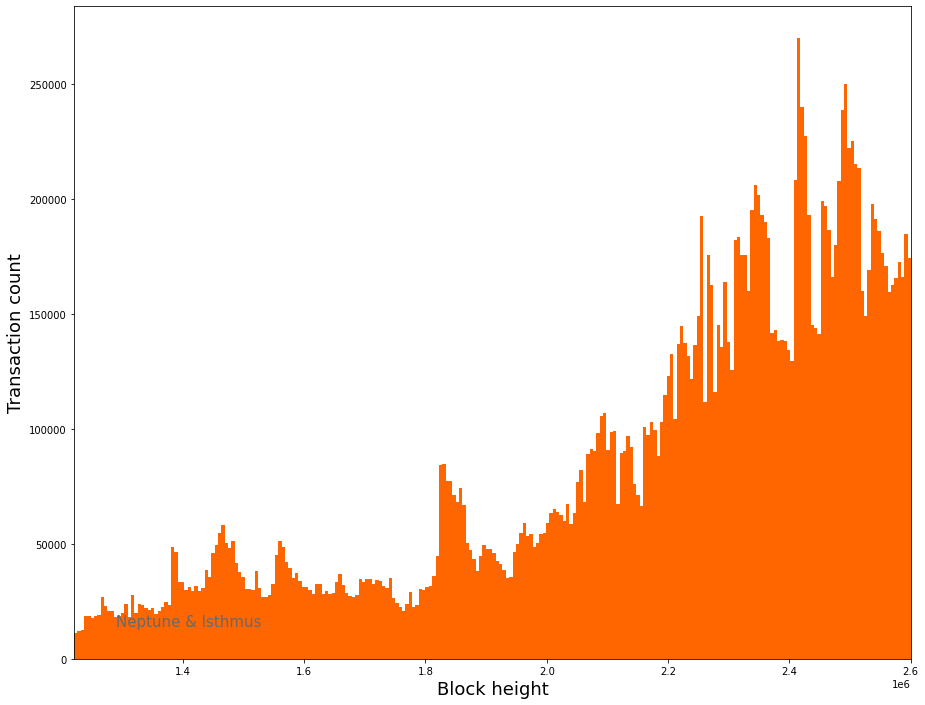

In [10]:
monero.hist('block_height', bins=250, ylabel='Transaction count');

### Fee distribution in 1D

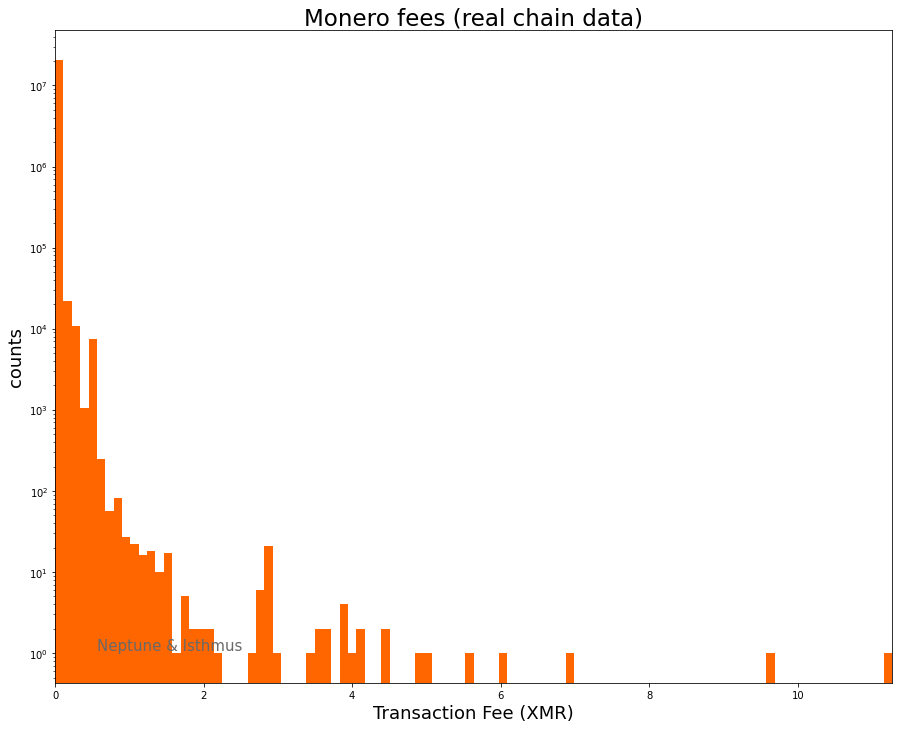

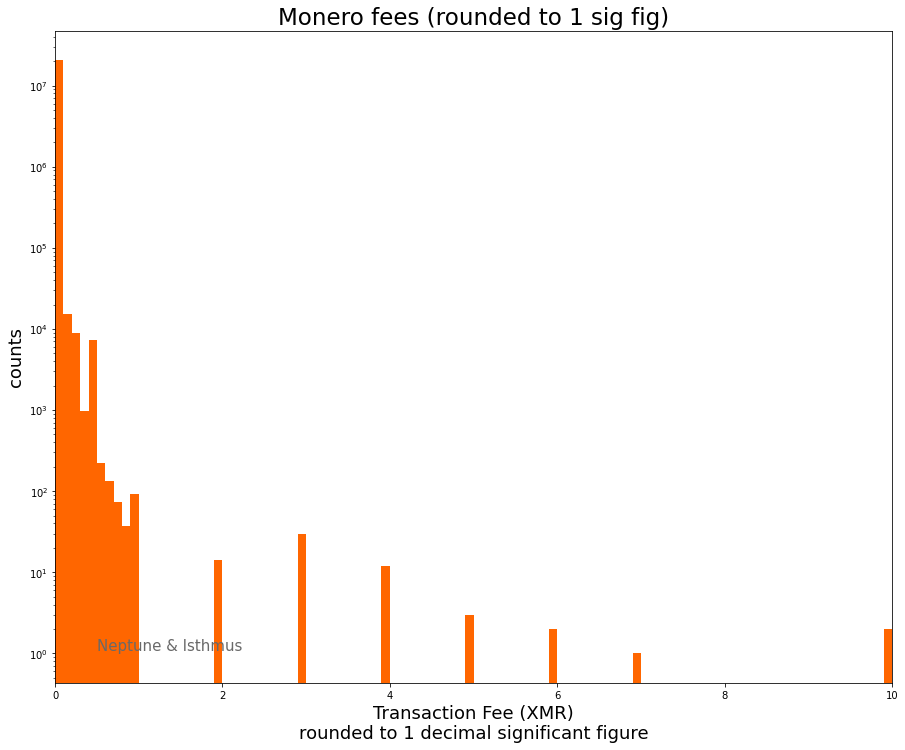

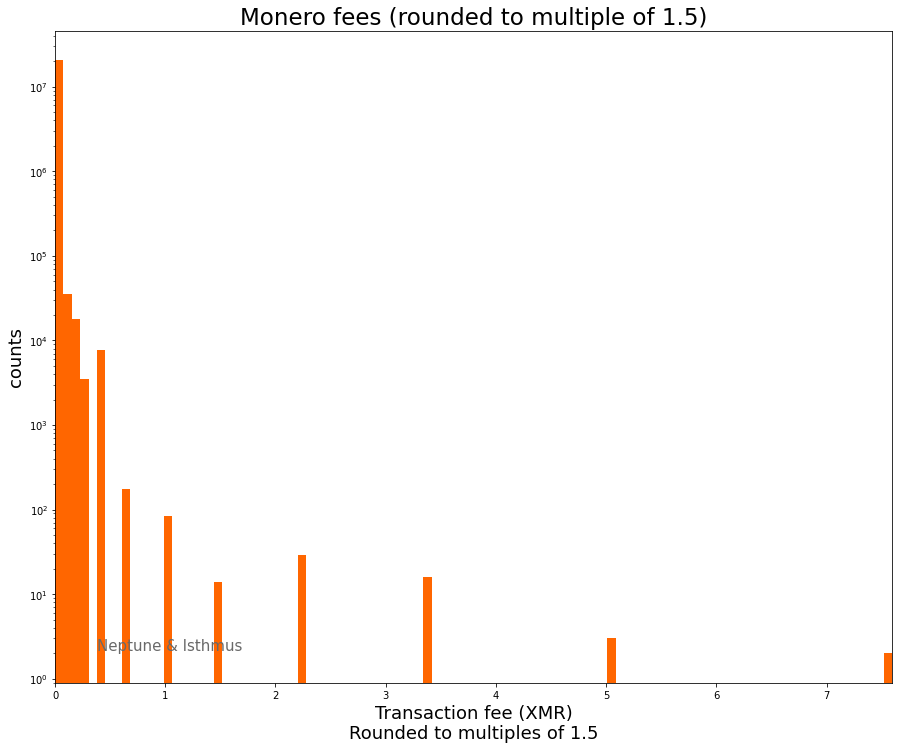

In [11]:
for field, title in field_title_tuples:
    monero.hist(field, log_axes='y', bins=100, title=title);

### Scatter plots

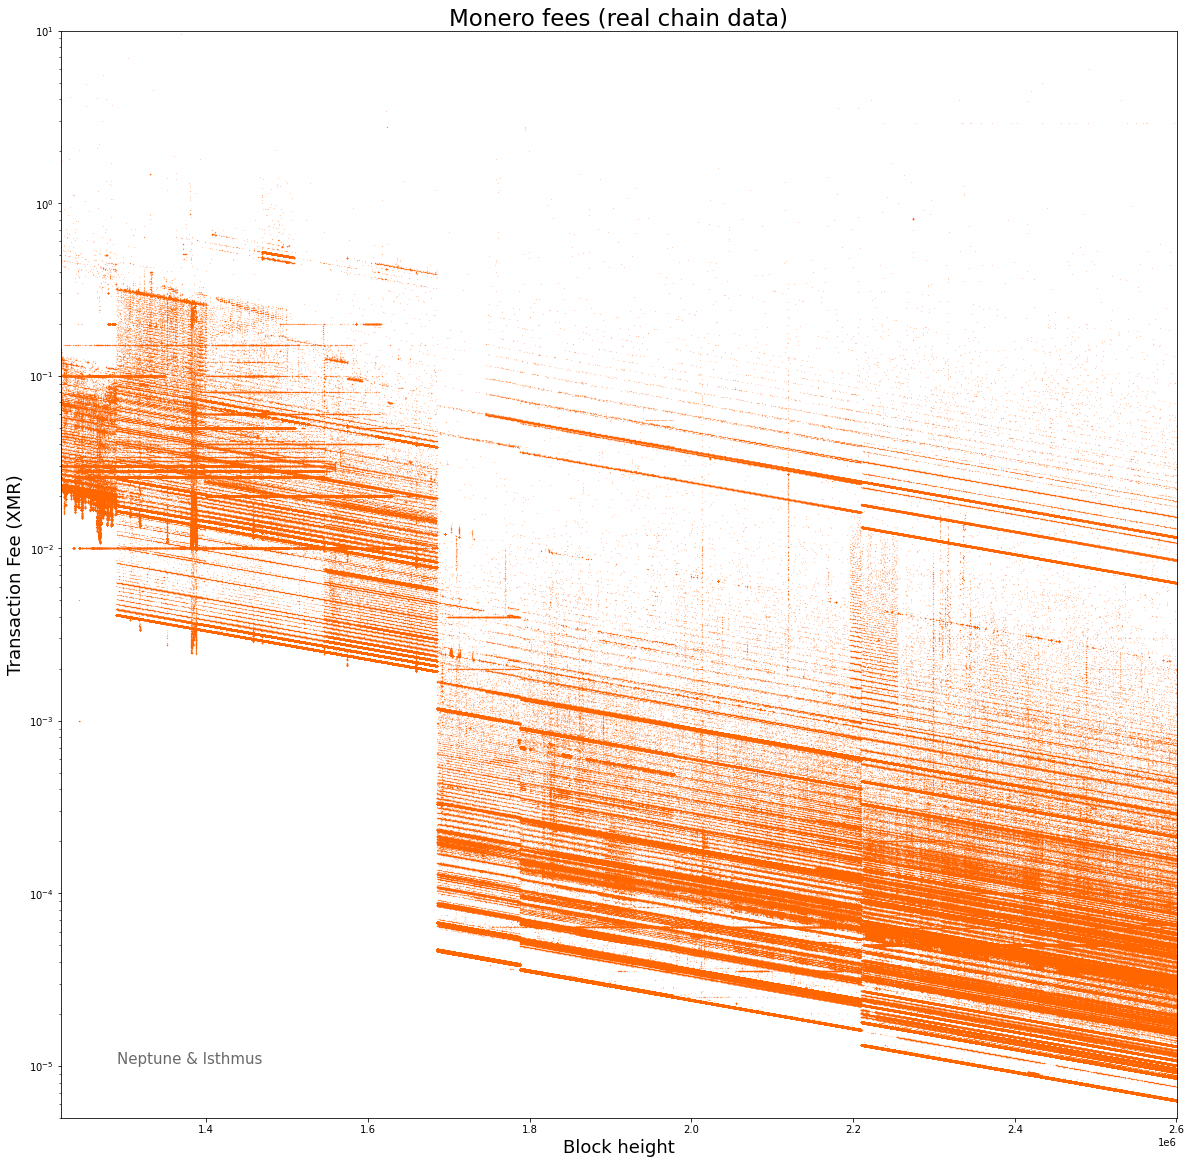

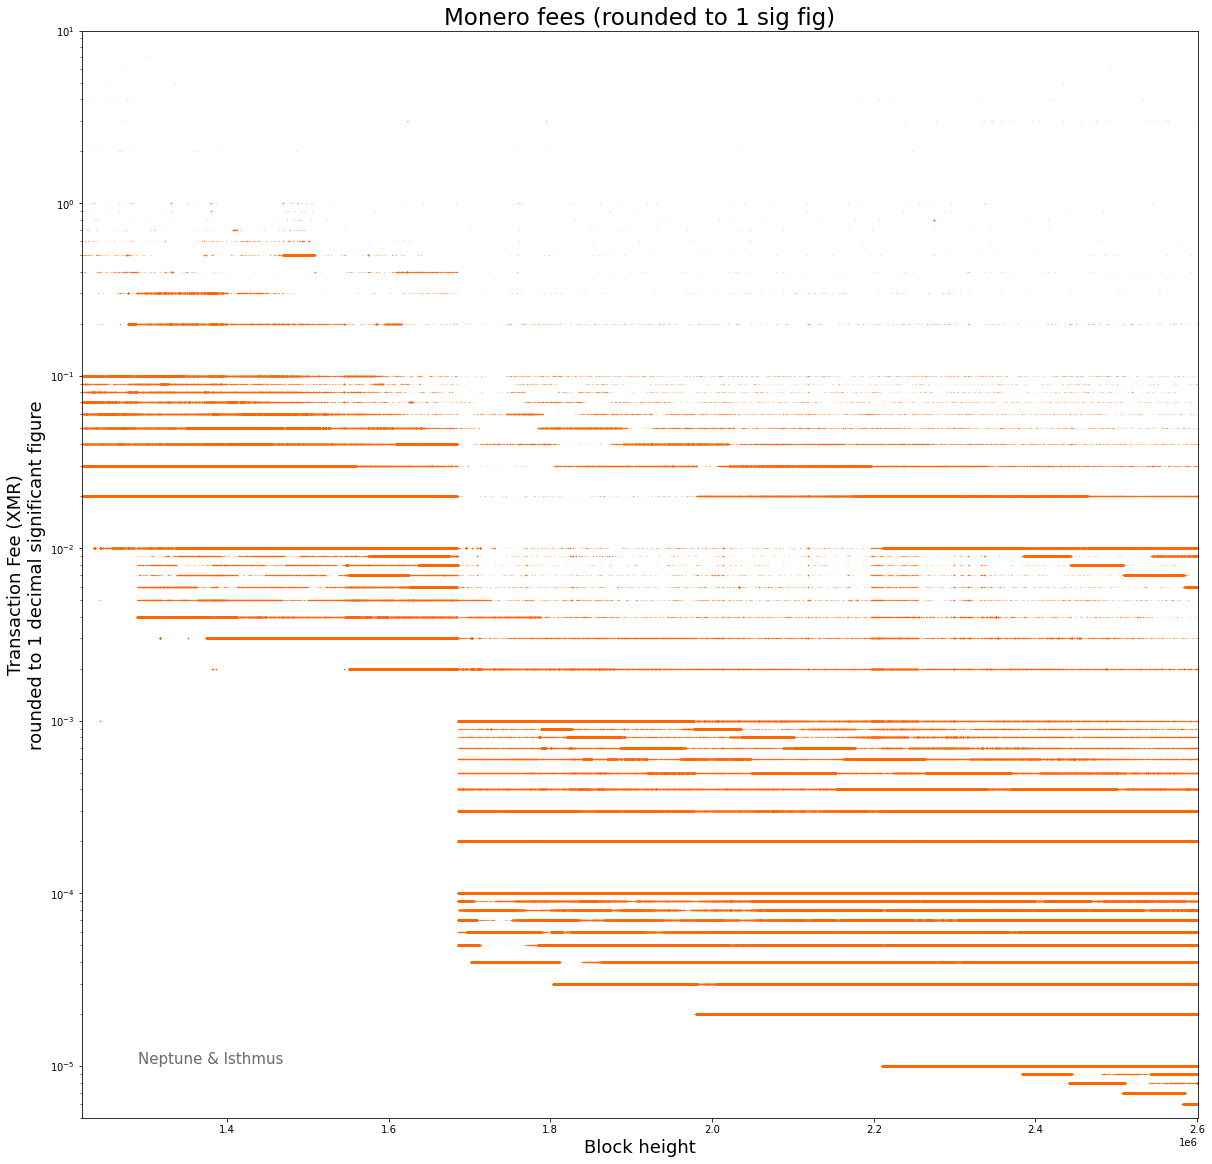

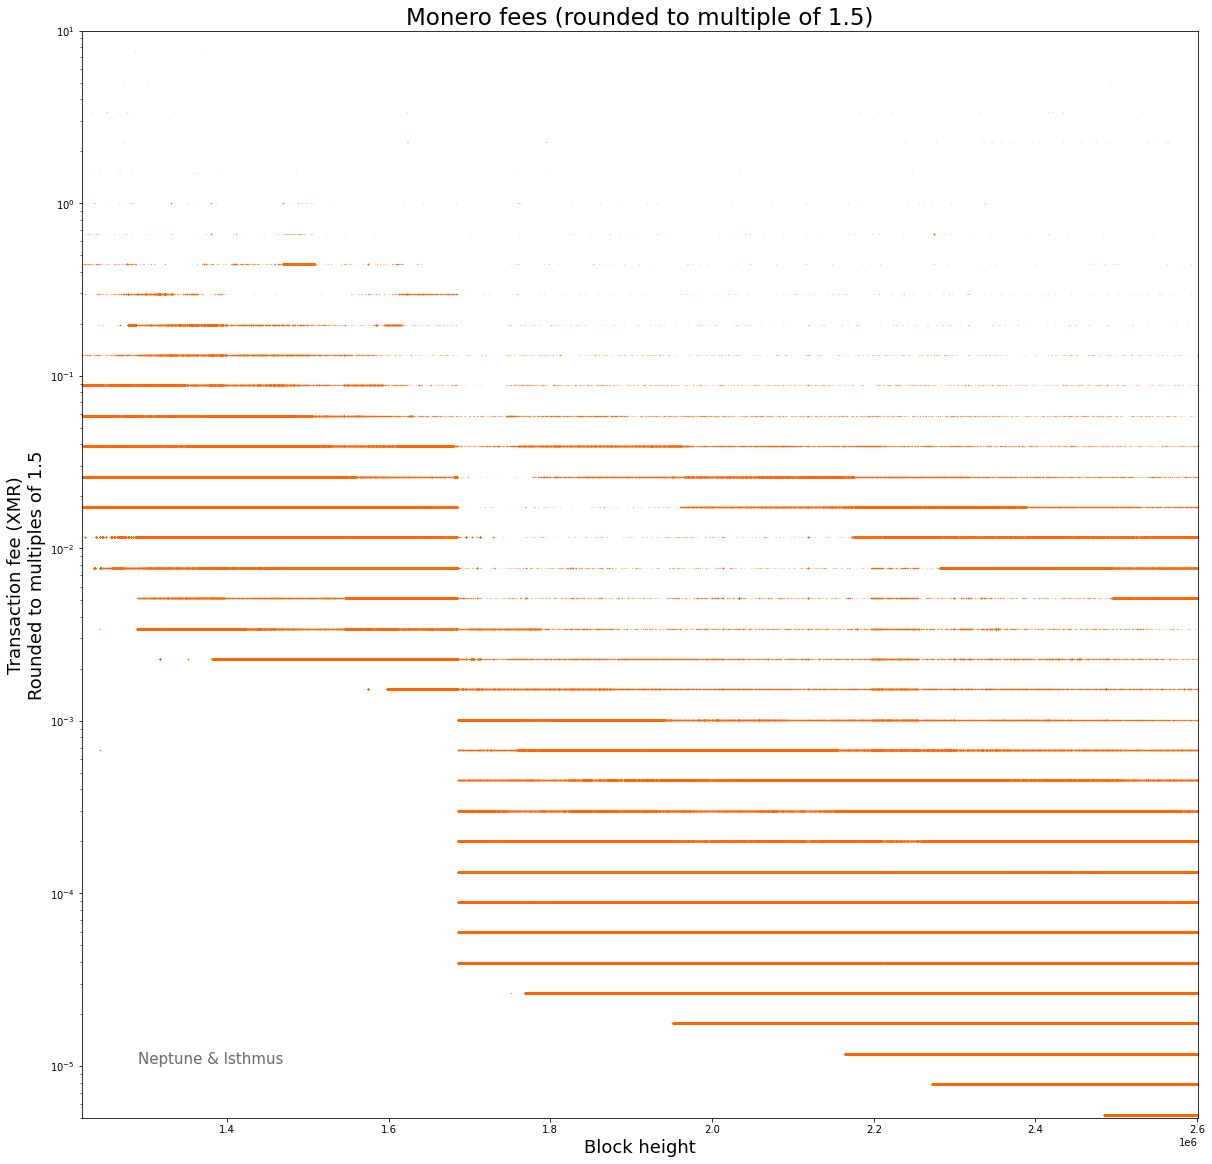

In [12]:
for field, title in field_title_tuples:
    monero.scatter(field, log_axes='y', markersize=0.01, figsize=(20,20), ylim=[5e-6, 10], title=title);

### Heatmaps

Same thing as scatter plots, just shown with some binning

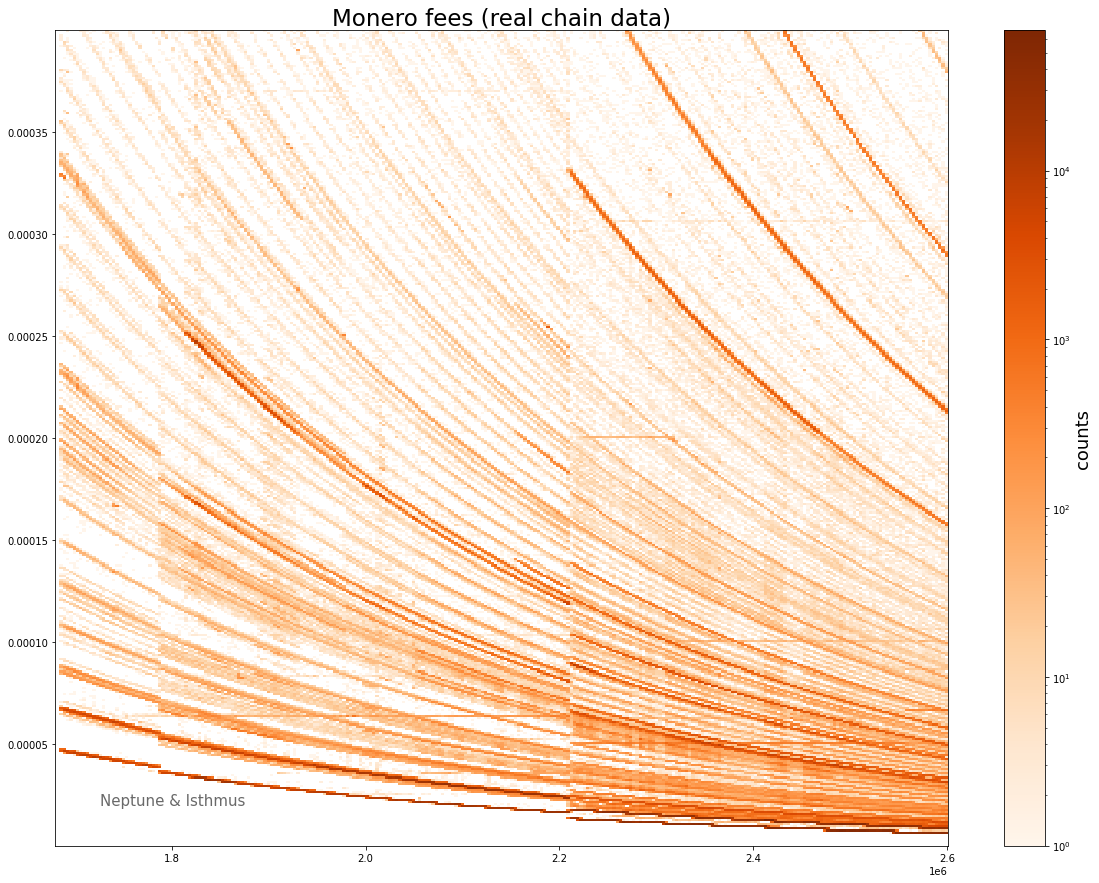

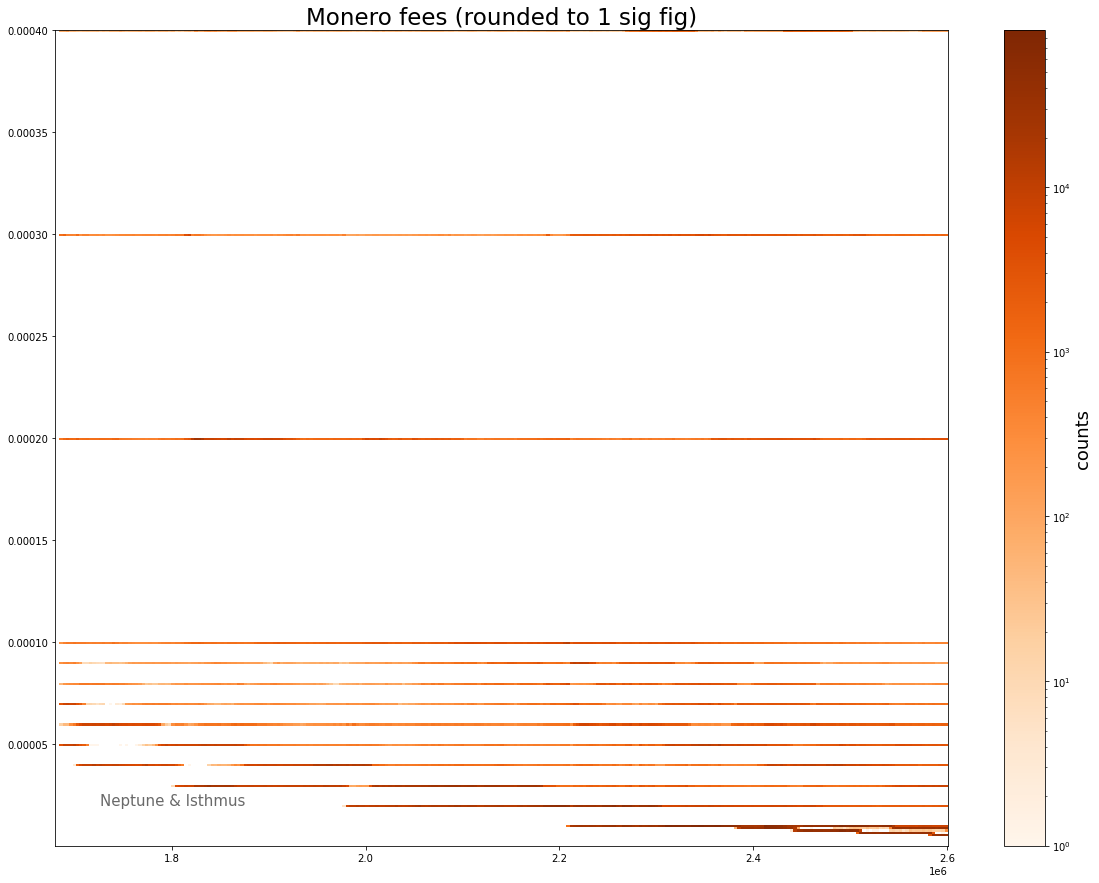

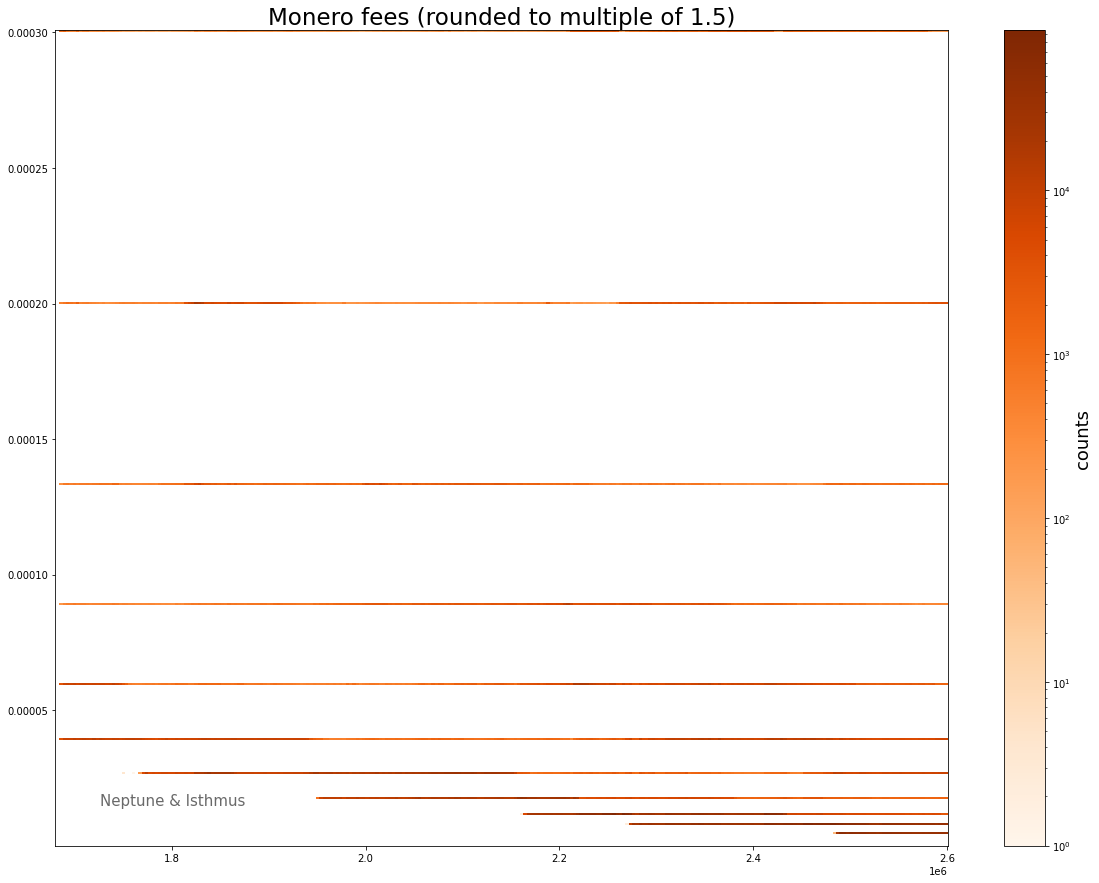

In [13]:
low_pass_filter = monero.data.tx_fee < 0.0004
for field, title in field_title_tuples:
    isthmuslib.hist2d(monero.data[low_pass_filter]['block_height'], monero.data[low_pass_filter][field], xlim=[1.68e6, None], figsize=(20, 15), bins=(400, 400), zscale='log', style=isthmuslib.Style(**monero.dict()).override({'sequential_cmap': 'Oranges'}), title=title);

## Clustering

_(I hacked the rest of this notebook together on a whim, it is kind of messy, sorry)_

Here we apply HDBSCAN (a density-based clustering algorithm) to transaction fee data, to illustrate that the trends visible to the human eye are obvious to computer vision as well. This is just an out of the box proof of concept, somebody (you?) could tune this for better classification performance.

First, take the N most recent transactions, and normalize them to zero mean and unit standard deviation (note I log transformed the fees first to help with scale)

In [14]:
%%time
use_n_most_recent: int = 700_000
inputs: pd.DataFrame = monero.data.sort_values(by='block_height', ascending=False, inplace=False).reset_index(inplace=False)
inputs = inputs.loc[:use_n_most_recent, ['block_height','tx_fee']]

def normalize(array: List[Any]) -> List[float]:
    mean: float = np.mean(array)
    std_dev: float = np.std(array)
    return [(x - mean) / std_dev for x in array]

inputs.dropna(inplace=True)
inputs = inputs[inputs['tx_fee'] > 0]
inputs['block_height'] = normalize(inputs['block_height'])
inputs['tx_fee'] = normalize(np.log2(inputs['tx_fee']))

CPU times: user 1.96 s, sys: 139 ms, total: 2.1 s
Wall time: 2.1 s


Visualize

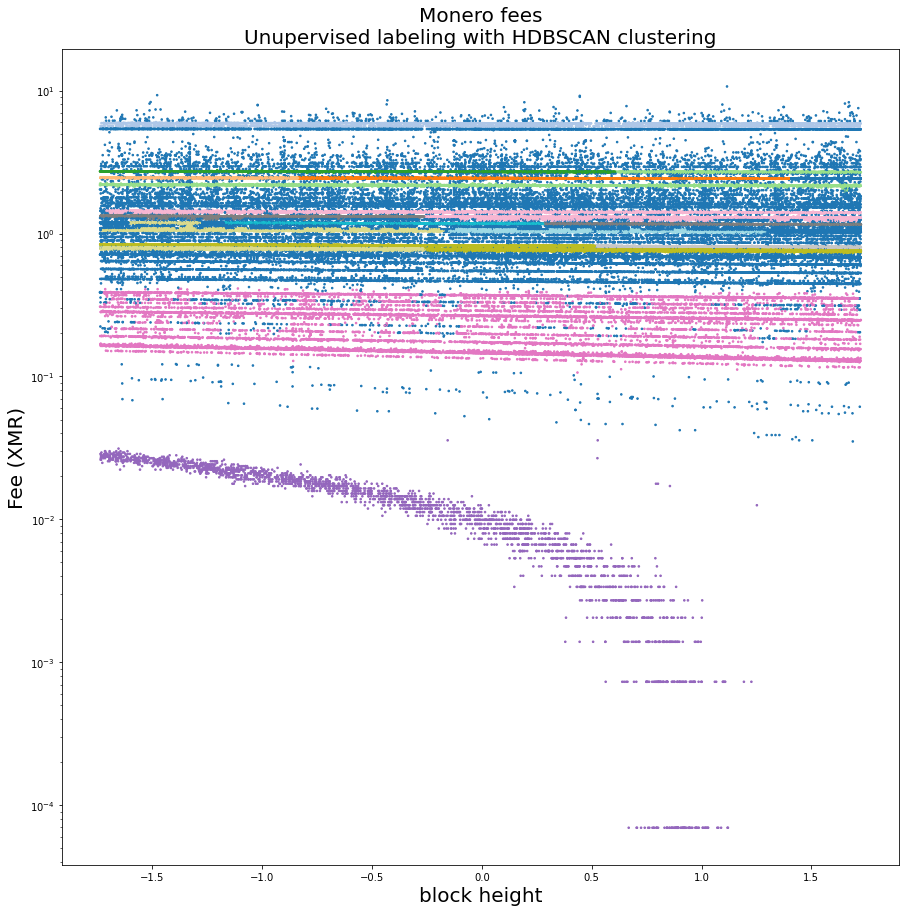

CPU times: user 12.3 s, sys: 5.86 s, total: 18.2 s
Wall time: 27.3 s


In [15]:
%%time
def cluster_and_plot(min_cluster_size: int = 2000, min_samples: int = 30, save: bool = False, close: bool = True)-> plt.Figure:
    # Cluster
    clusterer = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, min_samples = min_samples)
    inputs_temp: pd.DataFrame = deepcopy(inputs)
    clusterer.fit(inputs.to_numpy());
    
    # Plot
    f: plt.Figure = plt.figure(figsize=(15, 15), facecolor='w')
    plt.scatter(inputs.block_height, inputs_temp.tx_fee, c=clusterer.labels_, cmap='tab20', s=2.5)
    plt.yscale('log')
    plt.title(f"Monero fees\nUnupervised labeling with HDBSCAN clustering", fontsize=20)
    plt.xlabel('block height', fontsize=20)
    plt.ylabel('Fee (XMR)', fontsize=20)
    plt.show()
    if save:
        f.savefig((saved_to := cache_plots_path / f"_hdbscan {min_cluster_size=}_{min_size=}.png"))
    if close:
        plt.close()
    else:
        fig_handles.append(f)

cluster_and_plot();